# Homework 3
   
The homework consists of two parts: theoretical part (5 pts) and coding part (25 pts).
 - All theoretical questions must be answered in your own words, do not copy-paste text from the internet. Points can be deducted for terrible formatting or incomprehensible English.
 - Code must be commented. If you use code you found online, you have to add the link to the source you used. There is no penalty for using outside sources as long as you convince us you understand the code.
 - If you have hard time writing equations in markdown/latex in this notebook, write them on paper, take a good quality photo and add that photo to the notebook (make sure the file is incuded in your upload)

**You can earn up to 5 bonus points by tuning the hyperparameters and reaching test accuracies above 52%**

*Once completed zip the entire directory containing this exercise and upload it to https://courses.cs.ut.ee/2020/nn/spring/Main/Practices.*
   
For background reading see http://cs231n.github.io/optimization-2/  
http://vision.stanford.edu/teaching/cs231n/handouts/derivatives.pdf  
https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf



If you did this homework together with course mates, please write here their names (answers still have to be your own!).

**Name(s):** *fill this in if applicable*  
<br><br>


## Part 1: Lecture Materials (5 pts)

These theoretical questions are about the material covered in the lecture about "Back-propagation"
### Back-propagation

**Task 1.1: Derivatives of scalars, vectors and matrices (1pt)**  
In this task we ask you what are the dimensions of the gradient vector/matrix when taking the derivative of the object noted in the topmost row with respect to the object given in the first column. You can find help from http://cs231n.stanford.edu/handouts/derivatives.pdf 


Please fill in the table below:  

| $\frac{\partial}{\partial}$ | scalar | vector $\in \mathbb{R}^n$ |  
| ------ | ------ | ------ |
| scalar | ...  | ... |    
| vector $\in \mathbb{R}^k$ | ...	| ... |  


**Task 1.2: General rule of backprop (1pt)**  
You are given a feed-forward network with very many hidden layers. For the simplicity of this exercise, conisder that there is no non-linearity (no activation function) applied in the nodes. We note as $W_{i}$ the weight matrix that is between layers i and i+1. We note as $h_i$ the hidden node activations in layer i.

Considering that you already know the derivatives with respect to the hidden node activations in layer N+1, $\frac{\partial L}{\partial h_{N+1}}$, find the the following derivatives:  
$\frac{\partial L}{\partial W_N}=$   
$\frac{\partial L}{\partial h_N}=$   
$\frac{\partial L}{\partial W_{N-1}}=$     
$\frac{\partial L}{\partial h_{N-1}}=$   

Express the derivatives in function of the known derivative $\frac{\partial L}{\partial h_{N+1}}$, weight matrixes $W_i$ and hidden node activations $h_i$.

**Your Answer**: 

$\frac{\partial L}{\partial W_N}= \frac{\partial L}{\partial h_{N+1}} h_{i}$   
$\frac{\partial L}{\partial h_N}= \frac{\partial L}{\partial h_{N+1}} W_{i}$   
$\frac{\partial L}{\partial W_{N-1}}= \frac{\partial L}{\partial h_{N+1}} W_{i}h_{i-1}$    
$\frac{\partial L}{\partial h_{N-1}}= \frac{\partial L}{\partial h_{N+1}} W_{i}W_{i-1}$   

**Task 1.3: Complexity task 1 (1pt)**  

How many multiplications and how many additions/subtractions does it take to calculate:   
- the product of a vector $v \in \mathbb{R}^n$ and a matrix $M \in \mathbb{R}^{n \times m}$ (i.e. complexity of doing $v^T  M$)?

**Your Answer**: *fill this in.*

**Task 1.4: Complexity task 2 (2pt)**  

Imagine that you have a neural network with one hidden layer with 100 nodes (a "two-layer network", because it has two weight matrices), and you are using RELU activation function at the nodes. The inputs to the network are RGB images of size 32x32x3. The output is 10 probability values (obtained by passing the results through Softmax function). 

How many scalar operations (additions, subtractions, multiplications, divisions, exponentiations, logarithms and comparisons) does it take to:
   - perform a forward pass on one data point (to calculate the cross-entropy loss)

In [1]:
32*32*3

3072

**Your Answer**:

In [10]:
# Additions
firstLayer = (3071*100)+100
secondLayer = (99*10) + 100
softmaxFunction = 10
additions = firstLayer + secondLayer + softmaxFunction

print("Additions = " + repr(additions))

Additions = 308300


Substractions = 10 (Finding Loss)

In [12]:
# Multiplications
firstLayer = 3072 * 100
secondLayer = 100 * 100
multiplications = firstLayer + secondLayer
print("Multiplications = " + repr(multiplications))

Multiplications = 317200


- Divisions = 10 (Using Softmax Function)
- Exponentiations = 10 (Using Softmax Functions)
- Logarithms = 10 (Finding Loss)
- Comparisons = 200 (RELU Activation)

## Part 2: Practical Tasks (25 pts)
### Applied Theory

In this exercise we have a neural network with one hidden layer. This time we derive gradients slightly differently:
1. we use batch of samples instead of one sample,
2. **we use matrix calculus for gradients,**
3. we add L2 regularization to the loss.

![alt text][logo]

[logo]: http://cs231n.github.io/assets/nn1/neural_net.jpeg "Logo Title Text 2"


Notation:
 * $\mathbf{X}$ is $N \times D$ input matrix, where $N$ is number of samples in batch and $D$ is number of features.
 * $\mathbf{Y}$ is $N \times C$ one-hot coded target matrix, where $N$ is number of samples in batch and $C$ is number of classes.
 * $\mathbf{c}$ is $N$-dimensional vector of correct classes for all samples, $\mathbf{c}_i \in \{1, \ldots, C\}$.
 * $\mathbf{W}^{(1)}$ is $D \times M$ weight matrix of the first layer, where $D$ is the number of features and $M$ is number of hidden nodes.
 * $\mathbf{W}^{(2)}$ is $M \times C$ weight matrix of the second layer, where $M$ is the number of hidden nodes and $C$ is the number of classes.
 * $\mathbf{b}^{(1)}$ is bias vector of the first layer with dimension of $1 \times M$.
 * $\mathbf{b}^{(2)}$ is bias vector of the second layer with dimension of $1 \times C$.
 * $1_N$ is a column vector of ones of length N with dimension $N \times 1$
 * $\text{ReLU}(x) = \max(x, 0)$ is rectified linear unit activation function.
 * $\mathbf{P} = \text{softmax}(\mathbf{A})$ converts activations into probabilities row by row $\mathbf{P}_{ij} = \frac{e^ {\mathbf{A}_{ij}}}{\sum_k e^{\mathbf{A}_{ik}}}$.



**Feed-forward pass:**
$$
\begin{align*}
\mathbf{A}^{(1)} &= \mathbf{X} \mathbf{W}^{(1)} + 1_N \mathbf{b}^{(1)}   &(N\times M)
\\
\mathbf{H}^{(1)} &= \text{ReLU}(\mathbf{A}^{(1)}) &(N\times M)
\\
\mathbf{A}^{(2)} &= \mathbf{H}^{(1)} \mathbf{W}^{(2)} + 1_N \mathbf{b}^{(2)} &(N\times C)
\\
\mathbf{P} &= \text{softmax}(\mathbf{A}^{(2)}) &(N\times C)
\\
L_{CE} &= -\frac{1}{N} \sum_{i=1}^{N} \mathbf{Y}_{i\cdot} \odot \log \mathbf{P}_{i\cdot} = 
-\frac{1}{N} \sum_{i=1}^{N} \log \mathbf{P}_{i\mathbf{c}_i}   &(\text{scalar})
\end{align*}
$$

Here $AB$ is matrix multiplication and $A\odot B$ is element-wise multiplication.  
$\frac{1}{N}$ in the loss function produces mean instance loss, which is good because then loss value does not depend on batch size. If we had used sum, both loss value and gradients would have different magnitude for different batch sizes and we would need to adapt learning rate for each batch size.

<br><br>
**Backward pass:**  
Derivatives of matrix multiplication work very similarly to the scalar case. However, as the order of elements in product matters (AB $\neq$ BA), pay attention to transposes and also on which side of the overall expression the derviative ends up. Suppose  
  $$ L = f(Y),\qquad Y = XW.$$
Then
\begin{align*}
\frac{\partial L}{\partial X} &=  \frac{\partial L}{\partial Y} \frac{\partial Y}{\partial X}= \frac{\partial L}{\partial Y} \frac{\partial XW}{\partial X} =\frac{\partial L}{\partial Y} W^T\\
\frac{\partial L}{\partial W} &= \frac{\partial L}{\partial Y} \frac{\partial Y}{\partial W}= \frac{\partial L}{\partial Y} \frac{\partial XW}{\partial W} = X^T  \frac{\partial L}{\partial Y}.
\end{align*}
Notice that the multiplication with transposed matrix is from different sides in these two cases.

Backward pass for $\mathbf{W}^{(1)}$ using chain rule:
\begin{align*}
    \frac{\partial L_{CE}}{\partial\mathbf{W}^{(1)}} &= \frac{\partial L_{CE}}{\partial\mathbf{A}^{(1)}}\frac{\partial \mathbf{A}^{(1)}}{\partial\mathbf{W}^{(1)}} & \text{(chain rule)}\\
    &= X^T\frac{\partial L_{CE}}{\partial\mathbf{A}^{(1)}} & \text{(previous formula)}\\
    &= X^T\frac{\partial L_{CE}}{\partial\mathbf{H}^{(1)}}\frac{\partial\mathbf{H}^{(1)}}{\partial\mathbf{A}^{(1)}} & \text{(chain rule)}\\
    &= X^T\left(\frac{\partial L_{CE}}{\partial\mathbf{H}^{(1)}}\odot(\mathbf{A}^{(1)}>0)\right)\\
    &= X^T\left(\frac{\partial L_{CE}}{\partial\mathbf{A}^{(2)}}\frac{\partial\mathbf{A}^{(2)}}{\partial\mathbf{H}^{(1)}}\odot(\mathbf{A}^{(1)}>0)\right)&\text{(chain rule)}\\
    &= X^T\left(\left(\frac{\partial L_{CE}}{\partial\mathbf{A}^{(2)}}(\mathbf{W}^{(2)})^T\right)\odot(\mathbf{A}^{(1)}>0)\right)&\text{(previous formula)}\\
    &= \frac{1}{N}X^T\left(\left((P-Y)(\mathbf{W}^{(2)})^T\right)\odot(\mathbf{A}^{(1)}>0)\right)&\text{(from previous practice)}
\end{align*}
Here $(\mathbf{A}^{(1)}>0)$ denotes a matrix whose value at row $i$ and column $j$ is one, if the corresponding value in matrix $\mathbf{A}$ is greater than 0, and 0 otherwise.



### Task 2.1 (4pts)
Write down the partial derivatives of classification loss function with respect to other weights and biases. Verify that the dimensions match!

$$
\begin{align*}
\frac{\partial L_{CE}}{\partial\mathbf{W}^{(2)}} &= \frac{1}{N}H^{T}{P-Y} \qquad \qquad \qquad \qquad \qquad (M \times C)
\\
\frac{\partial L_{CE}}{\partial\mathbf{b}^{(1)}} &= \frac{1}{N}1_{N}^{T}(P-Y)W_{2}^{T}\odot (A^{1}>0) \qquad \qquad (M \times 1)
\\
\frac{\partial L_{CE}}{\partial\mathbf{b}^{(2)}} &= \frac{1}{N}1_{N}^{T}(P-Y) \qquad \qquad \qquad \qquad \qquad (C \times 1)
\end{align*}
$$



## L2 regularization

L2 regularization drives the weights to be small.
$$
L_r = \sum_{ij} (\mathbf{W}^{(1)}_{ij})^2 + \sum_{ij} (\mathbf{W}^{(2)}_{ij})^2
$$

In the final loss the classification loss and regularization loss are added together.
$$
L = L_c + \lambda L_r
$$

The strenght of regularization is determined by regularization coefficient $\lambda$.

### Task 2.2 (2pts):

Write down the partial derivatives of regularization loss with respect to weights:

$$
\begin{align*}
\frac{\partial L_r}{\partial\mathbf{W}^{(1)}} &= 2W^{1} \qquad \qquad \qquad \qquad (D \times M)
\\
\frac{\partial L_r}{\partial\mathbf{W}^{(2)}} &= 2W^{2} \qquad \qquad \qquad \qquad (M \times C)
\end{align*}
$$

In [31]:
# # Installing some required python libraries
# !conda install neural_net
# !conda install future

In [32]:
# A bit of setup
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use the class `TwoLayerNet` in the file `neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [33]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores

### Task 2.3 (2pts)
Open the file `neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the Softmax exercise: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores (activations in last layer, before softmax) for all inputs.

In [34]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.680272093239262e-08


# Forward pass: compute loss
### Task 2.4 (2pts)
In the same function, implement the second part that computes the Cross Entropy loss and regularizaion loss.

In [38]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.794120407794253e-13


# Backward pass
### Task 2.5 (6pts)
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [39]:
from gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.333333e-01
b2 max relative error: 4.447677e-11
W1 max relative error: 8.002490e-01
b1 max relative error: 2.738421e-09


# Train the network
### Task 2.6 (3pts)
To train the network we will use stochastic gradient descent (SGD), similar to the Softmax classifier. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the Softmax classifier. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.017149085837733294


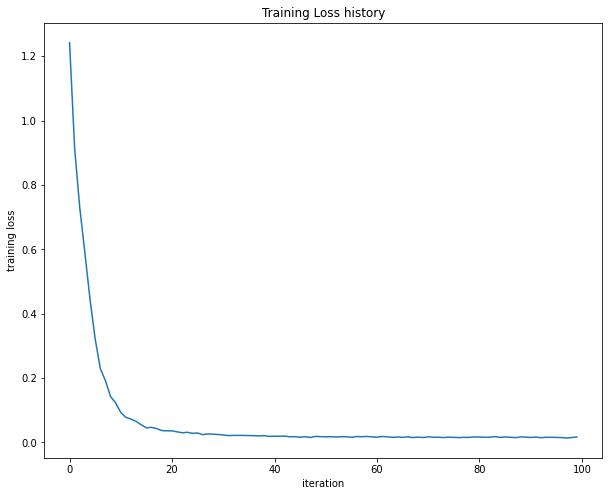

In [40]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [41]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a number smaller than one called "decay rate".

In [46]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302976
iteration 100 / 1000: loss 2.302486
iteration 200 / 1000: loss 2.298407
iteration 300 / 1000: loss 2.272552
iteration 400 / 1000: loss 2.159474
iteration 500 / 1000: loss 2.143454
iteration 600 / 1000: loss 2.069918
iteration 700 / 1000: loss 1.975231
iteration 800 / 1000: loss 1.950194
iteration 900 / 1000: loss 1.956903
Validation accuracy:  0.281


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

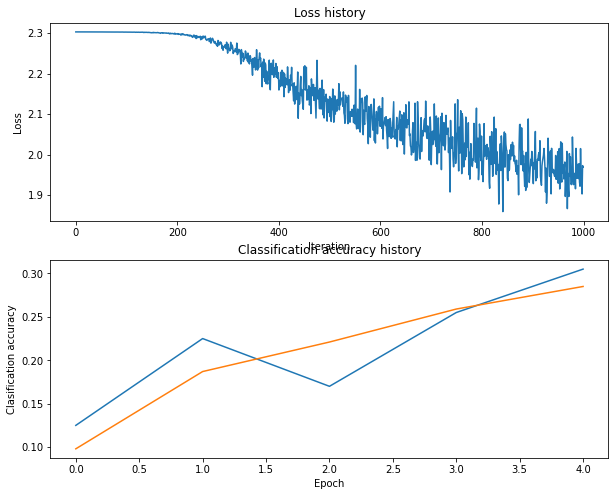

In [47]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

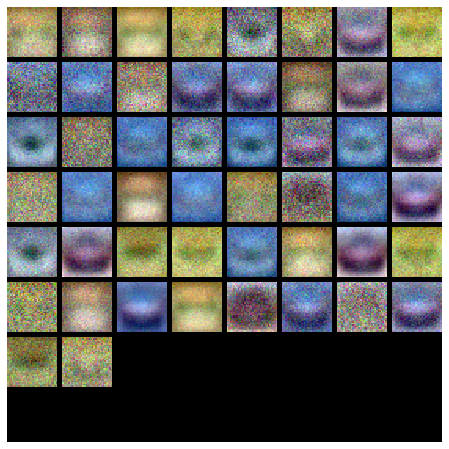

In [48]:
from vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

### Task 2.7 (4pts)
**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [ ]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# Initialize best value and best stat container
best_val = -1
best_stats = None
learning_rates=[1.8e-3]
reg_str=[1.5e-2]
batch_sizes=[400]
hidden_sizes=[400]
results={}
iters=4000

for i in learning_rates:
    for r_s in reg_str:
        for b_s in batch_sizes:
            for h in hidden_sizes:
                net=TwoLayerNet(input_size,h,num_classes)
                stats=net.train(X_train, y_train, X_val, y_val, num_iters=iters, batch_size=b_s, learning_rate=i, learning_rate_decay=0.95, reg=r_s)
                train_predict_y = net.predict(X_train)
                train_accuracy = np.mean(y_train==train_predict_y)
                val_predict_y=net.predict(X_val)
                validation_accuracy = np.mean(y_val == val_predict_y)
                results[(i,r_s,b_s,h)]=(train_accuracy,validation_accuracy)
                
                if best_val <validation_accuracy:
                    best_stats=stats
                    best_val = validation_accuracy
                    best_net=net
                    
print('Best validation during cross validation process = %f'% best_val)

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

### Task 2.8 (2pts):
Describe how different hyperparameters seem to affect the result and what might be their interactions. Which are the most important and which are less important? Be thorough and mention all hyperparameters you tried. Describe what you see, not general case from textbook.

**Your answer:**

- Based on what I see, `learning rate` is the most important parameters to increase the accuracy
- `Regularization Strength` is also the important variable with good influence on accuracy value
- `Batch size` and `hidden layer` are less important paramater due to their less impact in accuracy
- All the hyperparameters that I've tried as below:
    - Learning rate = tested values [1e-2, 1e-4, 1.4e-3, 1.8e-3]
    - Regularization strengths = tested values [1e-1, 1e-2, 1e-4, 1.2e-2, 1.4e-2, 1.5e-2, 1.8e-2]
    - Batch size = tested values [100, 200, 400]
    - Training epoch size = tested values [100, 200, 400]

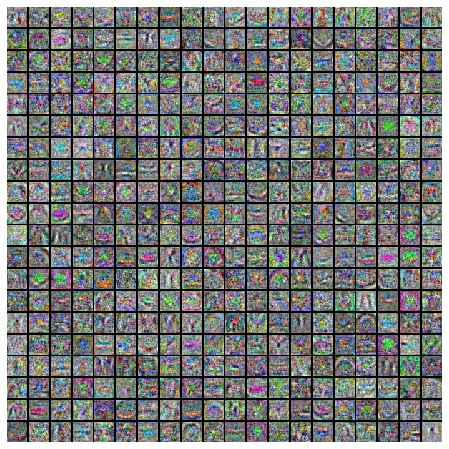

In [51]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

### Bonus Task (up to 5 pts):
**We will give you extra bonus point for every 1% of accuracy above 52%. (up to a maximum 5 bonus points)**

In [52]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.519
